In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from scipy import signal
import pandas as pd

from sklearn.metrics import r2_score
import imp

import sys
sys.path.append(sys.path[0][:-27])

from ikd import utils, core, evaluate, datasets, epca
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)
imp.reload(epca)

<module 'ikd.epca' from 'd:\\GT\\Lab\\ikd NeurIPS 2022\\src\\ikd\\epca.py'>

In [2]:
def group(x, dx):
    n = int(np.floor(x.shape[1] / dx))
    y = np.zeros((x.shape[0], n))
    for i in range(n):
        y[:, i] = np.mean(x[:, dx * i:dx * (i+1)], axis=1)
    return y

In [ ]:
z_true, spikes = datasets.hc_6("Con", 3, 2, show=True)
# v = np.diff(z_true, axis=0)
# z_true = np.array([(v[:, 0]**2 + v[:, 1]**2)**0.5, np.arctan2(v[:, 1], v[:, 0])]).T
# z_true = ((v[:, 0]**2 + v[:, 1]**2)**0.5)[:, np.newaxis] * 20
# spikes = spikes[:, :-1]

n, d = z_true.shape
kernel = "squared exponential"
extra_kernel_hyperparam = None
variance = 1
length_scale = 0.5

cov_true = utils.kernel_cov_generator(z_true, kernel=kernel, variance=variance, length_scale=length_scale, extra_kernel_hyperparam=extra_kernel_hyperparam)
# plt.matshow(cov_true)
# plt.colorbar()
# plt.title("True covariance matrix")

backward = "sqrt"
spikes_dense = utils.backward(spikes, method=backward)
cov_spikes = np.cov(spikes_dense)
variance_spikes = 2 * np.mean(cov_spikes)
cov_spikes_th = utils.filt_cov_samp(cov_spikes, variance_spikes)
cov_spikes_th = signal.convolve2d(cov_spikes_th, 1/121 * np.ones((11, 11)), boundary='symm', mode='same')
variance_spikes = 2 * np.mean(cov_spikes_th)
cov_spikes_th = utils.filt_cov_samp(cov_spikes_th, variance_spikes)

plt.matshow(cov_spikes_th)
plt.colorbar()
plt.title("Covariance matrix from spike train")

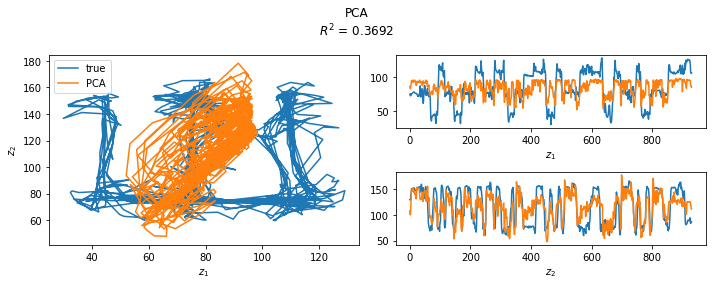

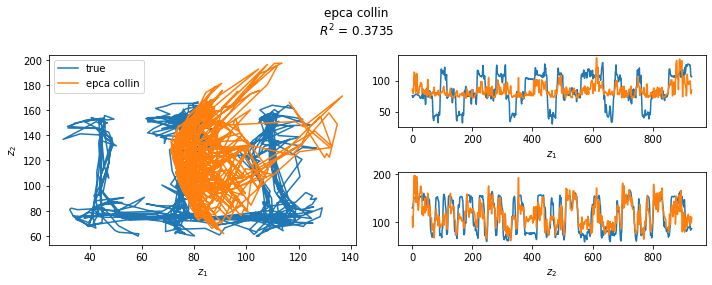

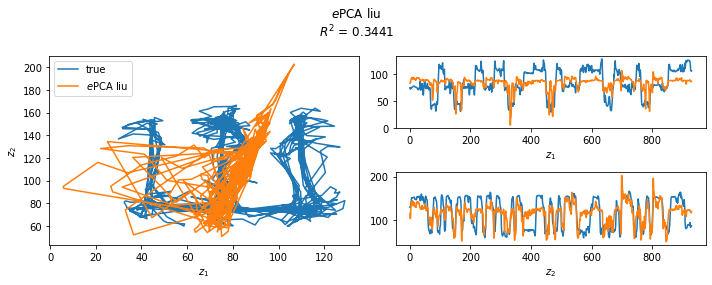

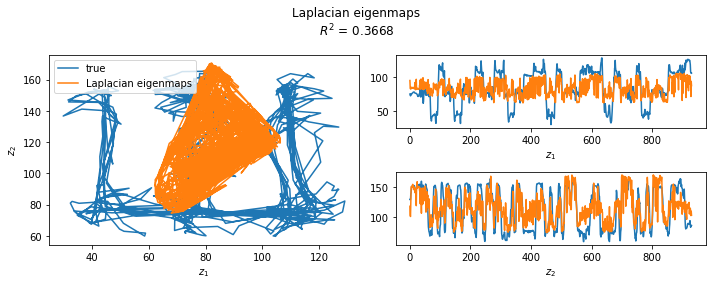

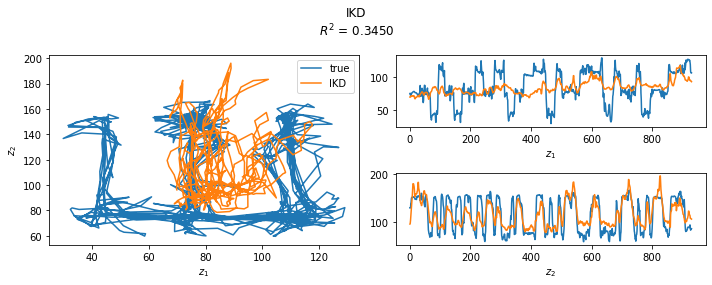

In [122]:
z_pca = PCA(n_components=d).fit_transform(spikes_dense) # pca
z_epca_collin = epca.poisson_pca(spikes, n_components=d)[0] # epca collin
z_epca_liu = epca.exp_fam_pca(spikes, "poisson", r=d)[3] # epca liu
evaluate.compare_latents(z_true, utils.align(z_true, utils.median_filter(z_pca)), "PCA")
evaluate.compare_latents(z_true, utils.align(z_true, utils.median_filter(z_epca_collin)), "epca collin")
evaluate.compare_latents(z_true, utils.align(z_true, utils.median_filter(z_epca_liu)), "$e$PCA liu")

z_le = SpectralEmbedding(n_components=d).fit_transform(spikes_dense)
evaluate.compare_latents(z_true, utils.align(z_true, z_le), "Laplacian eigenmaps")

z_ikd = core.ikd(cov_spikes_th, d, kernel=kernel, variance=variance_spikes, length_scale=1, extra_kernel_hyperparam=extra_kernel_hyperparam)[0]
# z_ikd_b = core.ikd_blockwise(cov_spikes_th, d, kernel=kernel, variance=variance_spikes, length_scale=1, extra_kernel_hyperparam=extra_kernel_hyperparam, clique_th_or_n_samples=0.1)
evaluate.compare_latents(z_true, utils.align(z_true, utils.median_filter(z_ikd)), "IKD")
# evaluate.compare_latents(z_true, utils.align(z_true, utils.median_filter(z_ikd_b)), "IKD-b")

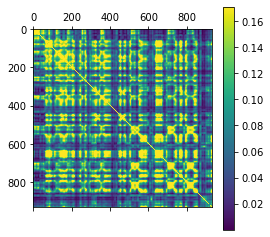

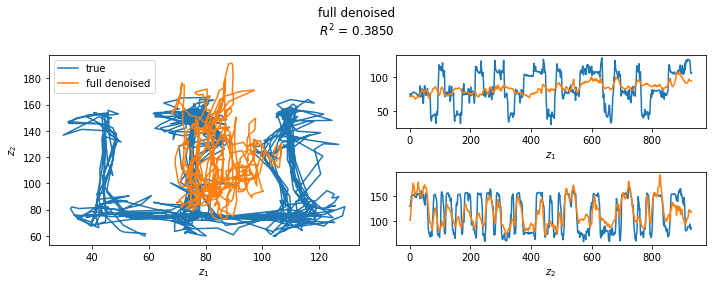

In [114]:
sol = epca.exp_fam_pca(spikes.T, "poisson", r=spikes.shape[1])
firing_rates_est = epca.wiener_filter(sol[0], spikes.T, "poisson").T

x_est = utils.backward(firing_rates_est, method=backward)
cov_est = np.cov(x_est)
variance_est = 2 * np.mean(cov_est)
cov_est_th = utils.filt_cov_samp(cov_est, variance_est)
cov_est_th = signal.convolve2d(cov_est_th, 1/121 * np.ones((11, 11)), boundary='symm', mode='same')
variance_est = 2 * np.mean(cov_est_th)
cov_est_th = utils.filt_cov_samp(cov_est_th, variance_est)

plt.matshow(cov_est_th)
plt.colorbar()
z_full_denoised = core.ikd(cov_est_th, d, kernel=kernel, variance=variance_est, length_scale=1)[0]
# z_block_denoised = core.ikd_blockwise(cov_est_th, d, kernel=kernel, variance=variance_est, length_scale=1, clique_th_or_n_samples=0.1)
evaluate.compare_latents(z_true, utils.align(z_true, utils.median_filter(z_full_denoised)), "full denoised")